所谓非线性可分问题，就是对于给定数据集，如果能用一个**超曲面**将正负实例正确分开，则这个问题为非线性可分问题。非线性问题的一个关键在于将原始数据空间转换到一个新的数据空间，在原始空间中的非线性可分问题到新空间就是是线性可分问题。

<font  size=3>核函数的作用就是隐含着一个从低维空间到高维空间的映射，而这个映射可以把低维空间中线性不可分的两类点变成线性可分的。

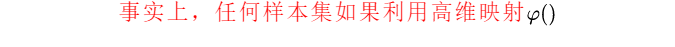

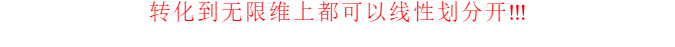

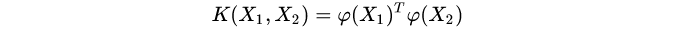

<font size = 3>核函数就是两无限维向量的内积,目的是代替**难以确定的，虚无缥缈的高维映射函数**

核函数的表达式，等号左边实际上是一个变量值，而等号右边是两无限维向量的内积，我们前面做的工作实际上就是引入了核函数，这里有个误区，核函数不是将低维度样本集线性不可分划分的方法，高维映射才是，核函数只是简化了这个过程，我们不需要去求解[公式]的具体形式而已！

<font size = 3> 求到最后，核函数K是一开始用户确定采用的那一种核函数（比如常见的高斯核函数和多项式核函数等），而待求的则是$\alpha_1$和$\alpha_2$（拉格朗日函数引入的），细心的朋友可能已经发现了，优化问题中的$\varphi(X)$都慢慢“消失”，被核函数K（X1,X2）代替，这就是前面我们折腾半天的原因，

### 软间隔SVM中优化目标如下：

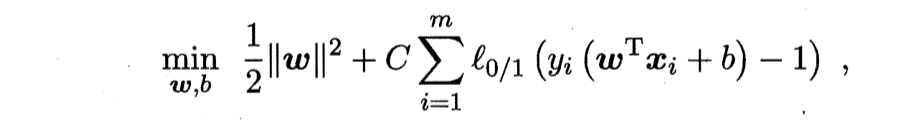

### $l_(0/1)$是0/1损失函数，非凸不连续，换用替代函数——hinge loss、指数损失、对率损失

In [5]:
# 定义多项式核函数如下：
def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

In [ ]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

class nolinear_svm(object):
    
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Gram 矩阵
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])
        
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
        
        # 求解二次规划
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        # 获得拉格朗日乘子
        a = np.ravel(solution['x'])
        
        # 非零拉格朗日乘子的支持向量
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))
        
        # 截距项
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)
        
        # 权重参数向量
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
            
    # 预测函数
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b
    
    def predict(self, X):
        return np.sign(self.project(X))


if __name__ == "__main__":
    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0, 0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2
    
    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train
    
    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test
    
    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            return (-w[0] * x - b + c) / w[1]
        
        pl.plot(X1_train[:, 0], X1_train[:, 1], "ro")
        pl.plot(X2_train[:, 0], X2_train[:, 1], "bo")
        pl.scatter(clf.sv[:, 0], clf.sv[:, 1], s=100, c="g")
        
        # w.x + b = 0
        a0 = -4;
        a1 = f(a0, clf.w, clf.b)
        b0 = 4;
        b1 = f(b0, clf.w, clf.b)
        pl.plot([a0, b0], [a1, b1], "k")
        
        # w.x + b = 1
        a0 = -4;
        a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4;
        b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0, b0], [a1, b1], "k--")
        
        # w.x + b = -1
        a0 = -4;
        a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4;
        b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0, b0], [a1, b1], "k--")
        
        pl.axis("tight")
        pl.show()
    
    
    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:, 0], X1_train[:, 1], "ro")
        pl.plot(X2_train[:, 0], X2_train[:, 1], "bo")
        pl.scatter(clf.sv[:, 0], clf.sv[:, 1], s=100, c="g")
        
        X1, X2 = np.meshgrid(np.linspace(-6, 6, 50), np.linspace(-6, 6, 50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
        
        pl.axis("tight")
        pl.show()
    
    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)
        
        clf = nolinear_svm(polynomial_kernel)
        clf.fit(X_train, y_train)
        
        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))
        
        plot_contour(X_train[y_train == 1], X_train[y_train == -1], clf)
    
    test_non_linear()